# Agricultural Crops Image Classifier Model  🌾 <br>Inuk
---




In [ ]:
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image

from tensorflow.keras import Sequential, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
tf.random.set_seed(50)

## [1] Data Loading
---

In [ ]:
colab_path = "/content/drive/MyDrive/Colab Notebooks"
file_path = colab_path + "/Kaggle/Agricultural-crops"

In [ ]:
labels = os.listdir(file_path)

In [ ]:
def change_image_type(path, type="png"):
    # make labels
    labels = os.listdir(path)

    img_num = 0

    for label in labels:
        img_path = path + "/" + label
        imgs = os.listdir(img_path)
        for img in imgs:
            img_file = img_path + "/" + img

            new_name = "new-image-" + str(img_num) + ".png"
            new_file = img_path + "/" + new_name

            im = Image.open(img_file)
            im.save(new_file, type)
            os.remove(img_file)
            img_num += 1

In [ ]:
# change_image_type(file_path, "png")

## [2] Data Preprocessing
---

In [ ]:
train_ds = image_dataset_from_directory(
    file_path,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=42,
    batch_size=64,
    image_size=(150,150)
)

val_ds = image_dataset_from_directory(
    file_path,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=42,
    batch_size=64,
    image_size=(150,150)
)

Found 829 files belonging to 30 classes.
Using 664 files for training.
Found 829 files belonging to 30 classes.
Using 165 files for validation.


In [ ]:
image_size = 150
input_shape = (image_size, image_size, 3)

resize_and_rescale = Sequential([
    preprocessing.Resizing(image_size, image_size),
    preprocessing.Rescaling(1./255)
])

data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.3, fill_mode="nearest"),
  preprocessing.RandomZoom(0.3, fill_mode="nearest"),
  preprocessing.RandomHeight(0.3),
  preprocessing.RandomWidth(0.3),
  preprocessing.RandomTranslation((-0.3, 0.3), (-0.3, 0.3), fill_mode="nearest"),
  preprocessing.RandomContrast(0.3)
])

## [3] Load Model
---

In [ ]:
# vgg19 모델 불러오기
vgg19 = VGG19(
    include_top = False,
    weights='imagenet',
    input_shape = input_shape
)

for layer in vgg19.layers:
    layer.trainable = False

## [4] Make Model
---

In [ ]:
model_vgg = Sequential([
    data_augmentation,
    resize_and_rescale, 
    vgg19,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(1024, activation="relu"),
    Dropout(0.4),
    Dense(1024, activation="relu"),
    Dropout(0.4),
    Dense(1024, activation="relu"),
    Dropout(0.4),
    Dense(30, activation="softmax")
])


model_vgg.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## [5] Train Model
---

In [ ]:
stop_cb = EarlyStopping(
    min_delta=0.001,
    patience=10,
    restore_best_weights=True
)

model_path = colab_path + "/Models/agricultural-crops/agricultural-crops-inuk.h5"

model_ckpt_cb = ModelCheckpoint(
    model_path,
    save_best_only=True
)

In [ ]:
his = model_vgg.fit(
    train_ds,
    epochs=150,
    callbacks=[model_ckpt_cb],
    validation_data=val_ds
)

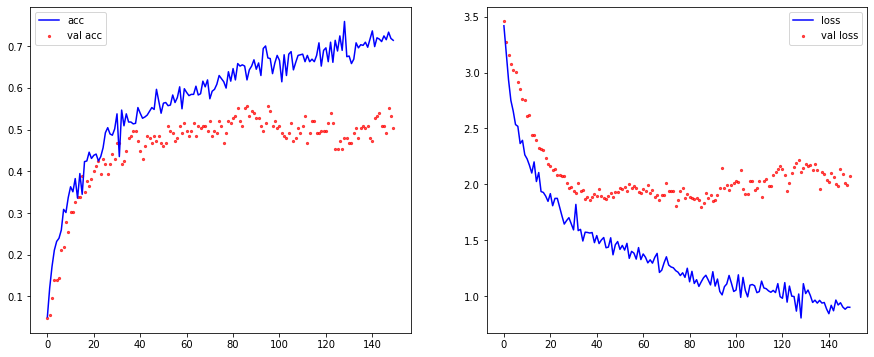

In [ ]:
x = his.epoch
acc = his.history["accuracy"]
val_acc = his.history["val_accuracy"]
loss = his.history["loss"]
val_loss = his.history["val_loss"]


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(x, acc, label="acc", color="blue")
plt.scatter(x, val_acc, label="val acc", color="red", alpha=0.7, s=5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, loss, label="loss", color="blue")
plt.scatter(x, val_loss, label="val loss", color="red", alpha=0.7, s=5)
plt.legend()

plt.show()